# Speech Emotion Recognition With Convolutional Neural Network

# Content
1. [Including Libraries](#1)
2. [Including the Datasets](#2)
3. [Data Analyze](#3)
    * [Audio Augmentation](#7)
        * [Original Audio](#4)
        * [Noised Audio](#8)
        * [Streched Audio](#10)
        * [Shifted Audio](#11)
        * [Pitched Audio](#12)
    * [Feature Extraction](#13)
    * [Processing](#14)
4. [Including Analyzed Audio Features](#15)
5. [Processing Analyzed Data for Training](#16)
    * [Train, Test and Validation Spliting](#17)
    * [Tuning for Training](#18)
6. [Begin Training](#19)
7. [Drawing Charts](#20)
    * [Accuracy Charts](#21)
    * [Loss Charts](#22)
8. [Testing Model and Test Results](#24)
    * [Confusion Matrix](#25)

<a id="1"></a>
# Including Libraries

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa
import librosa.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import IPython
import tensorflow.keras.layers as L
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
#from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder,StandardScaler
import re
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<a id="2"></a>
# Including the Datasets

In [ ]:
Crema_Path='../input/speech-emotion-recognition-en/Crema/'
Ravdess_Path='../input/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24'
Savee_Path='../input/speech-emotion-recognition-en/Savee/'
Tess_Path='../input/speech-emotion-recognition-en/Tess/'
subesco_path = '/kaggle/input/subescobangla-speech-emotion-dataset/SUBESCO'

<a id="3"></a>
# Data Analyze

In [ ]:
crema=[]
for wav in os.listdir(Crema_Path):
    emotion=wav.partition(".wav")[0].split('_')
    if emotion[2]=='SAD':
        crema.append(('sad',Crema_Path+'/'+wav))
    elif emotion[2]=='ANG':
        crema.append(('angry',Crema_Path+'/'+wav))
    elif emotion[2]=='DIS':
        crema.append(('disgust',Crema_Path+'/'+wav))
    elif emotion[2]=='FEA':
        crema.append(('fear',Crema_Path+'/'+wav))
    elif emotion[2]=='HAP':
        crema.append(('happy',Crema_Path+'/'+wav))
    elif emotion[2]=='NEU':
        crema.append(('neutral',Crema_Path+'/'+wav))
    else:
        crema.append(('unknown',Crema_Path+'/'+wav))
Crema_df=pd.DataFrame.from_dict(crema)
Crema_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Crema_df.head()

In [ ]:
Crema_df['Emotion'].unique()

In [ ]:
import os
import pandas as pd

# Initialize an empty list to store the file paths and emotions for SUBESCO
subesco = []

# Define the path to the SUBESCO dataset
SUBESCO_Path ='/kaggle/input/subescobangla-speech-emotion-dataset/SUBESCO'

# Iterate over each file in the SUBESCO directory
for wav in os.listdir(SUBESCO_Path):
    # Extract the emotion by splitting the filename
    parts = wav.partition(".wav")[0].split('_')
    
    # The emotion is located at index 4 according to the filename pattern provided
    emotion = parts[5]
    
    # Map the emotion codes to the corresponding emotion names
    if emotion == 'SAD':
        subesco.append(('sad', SUBESCO_Path + '/' + wav))
    elif emotion == 'ANGRY':
        subesco.append(('angry', SUBESCO_Path + '/' + wav))
    elif emotion == 'DISGUST':
        subesco.append(('disgust', SUBESCO_Path + '/' + wav))
    elif emotion == 'FEAR':
        subesco.append(('fear', SUBESCO_Path + '/' + wav))
    elif emotion == 'SURPRISE':
        subesco.append(('surprise', SUBESCO_Path + '/' + wav))
    elif emotion == 'HAPPY':
        subesco.append(('happy', SUBESCO_Path + '/' + wav))
    elif emotion == 'NEUTRAL':
        subesco.append(('neutral', SUBESCO_Path + '/' + wav))
    else:
        subesco.append(('unknown', SUBESCO_Path + '/' + wav))

# Convert the list to a DataFrame
Subesco_df = pd.DataFrame.from_records(subesco, columns=['Emotion', 'File_Path'])

# Display the first few rows of the DataFrame
Subesco_df.head()


In [ ]:
Subesco_df['Emotion'].unique()

In [ ]:
ravdess=[]
for directory in os.listdir(Ravdess_Path):
    actors=os.listdir(os.path.join(Ravdess_Path,directory))
    for wav in actors:
        emotion=wav.partition('.wav')[0].split('-')
        emotion_number=int(emotion[2])
        ravdess.append((emotion_number,os.path.join(Ravdess_Path,directory,wav)))
Ravdess_df=pd.DataFrame.from_dict(ravdess)
Ravdess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Ravdess_df['Emotion'].replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'},inplace=True)
Ravdess_df.head()

In [ ]:
Ravdess_df['Emotion'].unique()

In [ ]:
savee=[]
for wav in os.listdir(Savee_Path):
    emo=wav.partition('.wav')[0].split('_')[1].replace(r'[0-9]','')
    emotion=re.split(r'[0-9]',emo)[0]
    if emotion=='a':
        savee.append(('angry',Savee_Path+'/'+wav))
    elif emotion=='d':
        savee.append(('disgust',Savee_Path+'/'+wav))
    elif emotion=='f':
        savee.append(('fear',Savee_Path+'/'+wav))
    elif emotion=='h':
        savee.append(('happy',Savee_Path+'/'+wav))
    elif emotion=='n':
        savee.append(('neutral',Savee_Path+'/'+wav))
    elif emotion=='sa':
        savee.append(('sad',Savee_Path+'/'+wav))
    elif emotion=='su':
        savee.append(('surprise',Savee_Path+'/'+wav))
Savee_df=pd.DataFrame.from_dict(savee)
Savee_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Savee_df.head()

In [ ]:
Savee_df['Emotion'].unique()

In [ ]:
tess=[]
for directory in os.listdir(Tess_Path):
    for wav in os.listdir(os.path.join(Tess_Path,directory)):
        emotion=wav.partition('.wav')[0].split('_')
        if emotion[2]=='ps':
            tess.append(('surprise',os.path.join(Tess_Path,directory,wav)))
        else:
            tess.append((emotion[2],os.path.join(Tess_Path,directory,wav)))
Tess_df=pd.DataFrame.from_dict(tess)
Tess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Tess_df.head()

In [ ]:
Tess_df['Emotion'].unique()

In [ ]:
main_df=pd.concat([Crema_df,Ravdess_df,Savee_df,Tess_df,Subesco_df],axis=0)
main_df.shape

In [ ]:
main_df.head(15)

In [ ]:
main_df.tail(15)

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Emotions Counts')
emotions=sns.countplot(x='Emotion',data=main_df,palette='Set2')
emotions.set_xticklabels(emotions.get_xticklabels(),rotation=45)
plt.show()

In [ ]:
emotion_names=main_df['Emotion'].unique()

In [ ]:
colors={'disgust':'#804E2D','happy':'#F19C0E','sad':'#478FB8','neutral':'#4CB847','fear':'#7D55AA','angry':'#C00808','surprise':'#EE00FF'}

In [ ]:
def wave_plot(data,sr,emotion,color):
    plt.figure(figsize=(12,5))
    plt.title(f'{emotion} emotion for waveplot',size=17)
    librosa.display.waveshow(y=data,sr=sr,color=color)

In [ ]:
def spectogram(data,sr,emotion):
    audio=librosa.stft(data)
    audio_db=librosa.amplitude_to_db(abs(audio))
    plt.figure(figsize=(12,5))
    plt.title(f'{emotion} emotion for spectogram',size=17)
    librosa.display.specshow(audio_db,sr=sr,x_axis='time',y_axis='hz')

In [ ]:
audio_path=[]
for emotion in emotion_names:
    path=np.array(main_df['File_Path'][main_df['Emotion']==emotion])[1]
    data,sr=librosa.load(path)
    wave_plot(data,sr,emotion,colors[emotion])
    spectogram(data,sr,emotion)
    audio_path.append(path)

In [ ]:
print('Disgust Audio Sample\n')
IPython.display.Audio(audio_path[0])

In [ ]:
print('Happy Audio Sample\n')
IPython.display.Audio(audio_path[1])

In [ ]:
print('Sad Audio Sample\n')
IPython.display.Audio(audio_path[2])

In [ ]:
print('Neutral Audio Sample\n')
IPython.display.Audio(audio_path[3])

In [ ]:
print('Fear Audio Sample\n')
IPython.display.Audio(audio_path[4])

In [ ]:
print('Angry Audio Sample\n')
IPython.display.Audio(audio_path[5])

In [ ]:
print('Surprise Audio Sample\n')
IPython.display.Audio(audio_path[6])

<a id="7"></a>
## Audio Augmentation

In [ ]:
def add_noise(data,random=False,rate=0.035,threshold=0.075):
    if random:
        rate=np.random.random()*threshold
    noise=rate*np.random.uniform()*np.amax(data)
    augmented_data=data+noise*np.random.normal(size=data.shape[0])
    return augmented_data

def shifting(data,rate=1000):
    augmented_data=int(np.random.uniform(low=-5,high=5)*rate)
    augmented_data=np.roll(data,augmented_data)
    return augmented_data

def pitching(data,sr,pitch_factor=0.7,random=False):
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(y=data,sr=sr,n_steps = pitch_factor)

def streching(data,rate=0.8):
    return librosa.effects.time_stretch(y = data,rate= rate)
    
    

In [ ]:
data,sr=librosa.load(audio_path[6])

<a id="4"></a>
### Orijinal Audio

In [ ]:
plt.figure(figsize=(12,5))
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
librosa.display.waveshow(y=data, sr=sr, color='#EE00FF')

IPython.display.Audio(audio_path[6])

<a id="8"></a>
### Noised Audio

In [ ]:
noised_audio=add_noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=noised_audio,sr=sr,color='#EE00FF')
IPython.display.Audio(noised_audio,rate=sr)

<a id="10"></a>
### Streched Audio

In [ ]:
stretched_audio=streching(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y = stretched_audio,sr = sr,color='#EE00FF')
IPython.display.Audio(stretched_audio,rate=sr)

<a id="11"></a>
### Shifted Audio

In [ ]:
shifted_audio=shifting(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y = shifted_audio,sr = sr,color='#EE00FF')
IPython.display.Audio(shifted_audio,rate=sr)

<a id="12"></a>
### Pitched Audio

In [ ]:
pitched_audio=pitching(data,sr)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y = pitched_audio,sr = sr,color='#EE00FF')
IPython.display.Audio(pitched_audio,rate=sr)

<a id="13"></a>
## Feature Extraction

In [ ]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      #zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data,sr)
    audio=np.array(aud)
    
    noised_audio=add_noise(data,random=True)
    aud2=extract_features(noised_audio,sr)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitching(data,sr,random=True)
    aud3=extract_features(pitched_audio,sr)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitching(data,sr,random=True)
    pitched_noised_audio=add_noise(pitched_audio1,random=True)
    aud4=extract_features(pitched_noised_audio,sr)
    audio=np.vstack((audio,aud4))
    
    return audio
def rmse(data, frame_length=2048, hop_length=512):
    # Specify 'y' as the keyword for data
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)


<a id="14"></a>
## Processing

In [ ]:
X,Y=[],[]
for path,emotion,index in zip(main_df.File_Path,main_df.Emotion,range(main_df.File_Path.shape[0])):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')

In [ ]:
processed_data_path='./processed_data.csv'

In [ ]:
extract=pd.DataFrame(X)
extract['Emotion']=Y
extract.to_csv(processed_data_path,index=False)
extract.head(10)

<a id="15"></a>
# Including Analyzed Audio Features

In [ ]:
df=pd.read_csv(processed_data_path)
df.shape

In [ ]:
df=df.fillna(0)
print(df.isna().any())
df.shape

In [ ]:
df.head(10)

<a id="16"></a>
# Processing Analyzed Data for Training

In [ ]:
X=df.drop(labels='Emotion',axis=1)
Y=df['Emotion']

In [ ]:
lb=LabelEncoder()
#Y=np_utils.to_categorical(lb.fit_transform(Y))
Y=to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y

<a id="17"></a>
## Train, Test and Validation Spliting

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,random_state=42,test_size=0.2,shuffle=True)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

In [ ]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,random_state=42,test_size=0.1,shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape,y_test.shape,y_val.shape

In [ ]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
X_val=scaler.transform(X_val)
X_train.shape,X_test.shape,X_val.shape,y_train.shape,y_test.shape,y_val.shape

In [ ]:
X_train=np.expand_dims(X_train,axis=2)
X_val=np.expand_dims(X_val,axis=2)
X_test=np.expand_dims(X_test,axis=2)
X_train.shape, X_test.shape, X_val.shape

<a id="18"></a>
## Tuning for Training

In [ ]:
early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [ ]:
EPOCH=100
BATCH_SIZE=64

<a id="19"></a>
# Begin Training

In [ ]:
mode1l=tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
#model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model

# Define the CNN part
cnn_input = tf.keras.Input(shape=(X_train.shape[1], 1))
x = L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(cnn_input)
x = L.BatchNormalization()(x)
x = L.MaxPool1D(pool_size=5, strides=2, padding='same')(x)
x = L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(x)
x = L.BatchNormalization()(x)
x = L.MaxPool1D(pool_size=5, strides=2, padding='same')(x)
x = L.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(x)
x = L.BatchNormalization()(x)
x = L.MaxPool1D(pool_size=5, strides=2, padding='same')(x)
x = L.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = L.BatchNormalization()(x)
x = L.MaxPool1D(pool_size=5, strides=2, padding='same')(x)
x = L.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = L.BatchNormalization()(x)
cnn_output = L.MaxPool1D(pool_size=3, strides=2, padding='same')(x)

# Flatten CNN output for concatenation later
cnn_output_flattened = L.Flatten()(cnn_output)

# Define the Transformer Encoder part
# Input shape matches CNN output for concatenation purposes
transformer_input = L.Reshape((-1, 128))(cnn_output)  # Reshape CNN output to match transformer input
transformer_encoder = L.MultiHeadAttention(num_heads=8, key_dim=128)(transformer_input, transformer_input)
transformer_encoder = L.LayerNormalization()(transformer_encoder)
transformer_output = L.Flatten()(transformer_encoder)  # Flatten for concatenation

# Concatenate CNN and Transformer outputs
concatenated = L.Concatenate()([cnn_output_flattened, transformer_output])

# Dense Layers
x = L.Dense(512, activation='relu')(concatenated)
x = L.BatchNormalization()(x)
output = L.Dense(7, activation='softmax')(x)

# Define and compile the model
model = Model(inputs=cnn_input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


In [ ]:
history=model.fit(X_train, y_train, epochs=EPOCH, validation_data=(X_val,y_val), batch_size=BATCH_SIZE)

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('/kaggle/working/res_model.h5')


In [142]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks with appropriate mode
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, epochs=1, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, callbacks=[early_stop, lr_reduction])


863/863 ━━━━━━━━━━━━━━━━━━━━ 201s 233ms/step - accuracy: 0.9936 - loss: 0.0210 - val_accuracy: 0.9455 - val_loss: 0.2506 - learning_rate: 0.0010


<a id="20"></a>
# Drawing Charts

<a id="21"></a>
## Accuracy Charts

In [146]:
fig=px.line(history.history,y=['accuracy','val_accuracy'],
           labels={'index':'epoch','value':'accuracy'},
           title=f'According to the epoch accuracy and validation accuracy chart for the model with RMSE and MFCC  feature')
fig.show()

<a id="22"></a>
## Loss Charts

In [145]:
fig=px.line(history.history,y=['loss','val_loss'],
           labels={'index':'epoch','value':'loss'},
           title=f'According to the epoch loss and validation loss chart for the model with RMSE and MFCC  feature')')
fig.show()

SyntaxError: unterminated string literal (detected at line 3) (4182460213.py, line 3)

<a id="24"></a>
# Testing Model and Test Results

In [147]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

I0000 00:00:1731001233.753243    1420 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 192 bytes spill stores, 192 bytes spill loads



478/480 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

I0000 00:00:1731001255.002675    1443 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 192 bytes spill stores, 192 bytes spill loads



480/480 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step


array([0, 0, 6, ..., 4, 6, 6])

In [148]:
y_check=np.argmax(y_test,axis=1)
y_check

array([0, 0, 6, ..., 5, 6, 6])

In [149]:
loss,accuracy=model.evaluate(X_test,y_test,verbose=0)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Test Loss: 0.2801218032836914
Test Accuracy: 0.9386823177337646


<a id="25"></a>
## Confusion Matrix

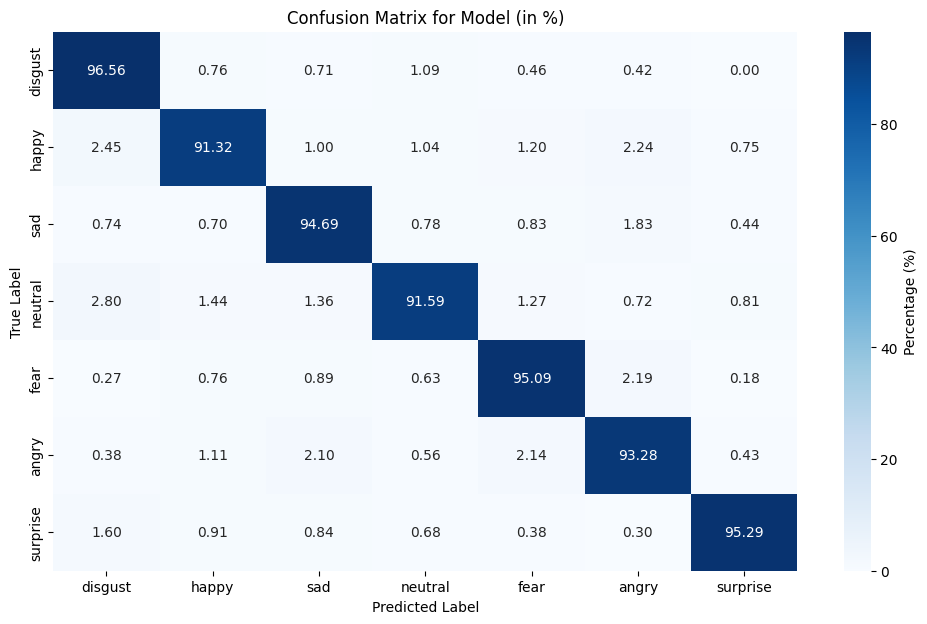

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf = confusion_matrix(y_check, y_pred)

# Normalize the confusion matrix to get percentages
conf_percent = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis] * 100

# Convert the confusion matrix to a DataFrame with labeled rows and columns
cm = pd.DataFrame(
    conf_percent, 
    index=[i for i in emotion_names], 
    columns=[i for i in emotion_names]
)

# Plot the confusion matrix with percentages
plt.figure(figsize=(12, 7))
ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Percentage (%)'})
ax.set_title('Confusion Matrix for Model (in %)')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()


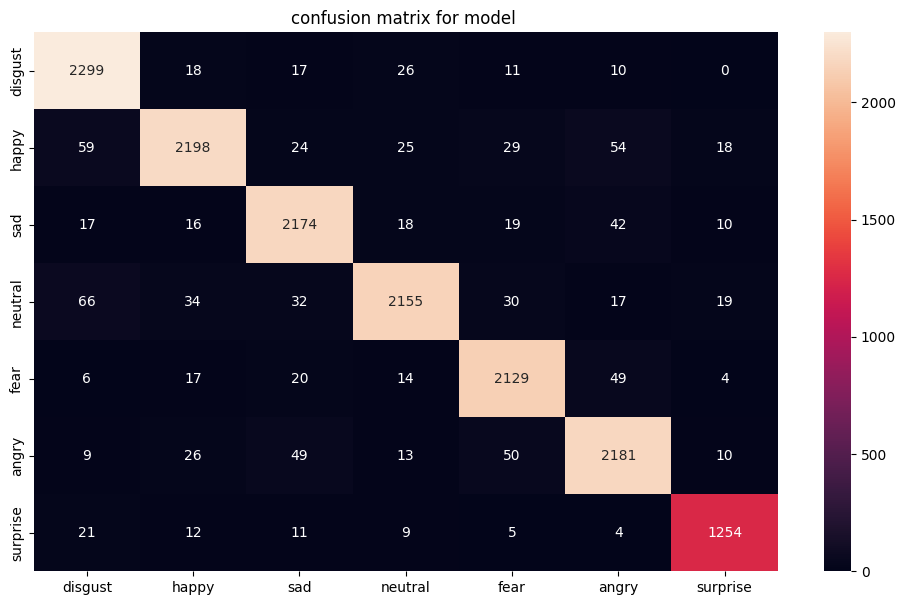

In [150]:
conf=confusion_matrix(y_check,y_pred)
cm=pd.DataFrame(
    conf,index=[i for i in emotion_names],
    columns=[i for i in emotion_names]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'confusion matrix for model ')
plt.show()

In [151]:
print(f'Model Confusion Matrix\n',classification_report(y_check,y_pred,target_names=emotion_names))

Model Confusion Matrix
               precision    recall  f1-score   support

     disgust       0.93      0.97      0.95      2381
       happy       0.95      0.91      0.93      2407
         sad       0.93      0.95      0.94      2296
     neutral       0.95      0.92      0.93      2353
        fear       0.94      0.95      0.94      2239
       angry       0.93      0.93      0.93      2338
    surprise       0.95      0.95      0.95      1316

    accuracy                           0.94     15330
   macro avg       0.94      0.94      0.94     15330
weighted avg       0.94      0.94      0.94     15330



In [152]:
model_path = "./res_model.h5"

model.save(model_path)